In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Input
from scipy.stats import pearsonr
from matplotlib import pyplot as plt



Prepare the data into scaled values

In [12]:
wine_df = pd.read_csv('../wine+quality/winequality-white.csv', sep=';')

X_orig = wine_df.drop('quality', axis=1)
X = StandardScaler().fit_transform(X_orig)
y = wine_df['quality']


Train the SVR model with a 3:1 train-test split

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)


In [14]:

def train_svr(X_train, y_train):
    model = SVR(kernel='rbf', C=0.95, epsilon=0.13)
    model.fit(X_train, y_train)
    return model

svr = train_svr(X_train, y_train)


Train the ANN model with a 3:1:1 train-validation-test split

In [15]:



def train_ann(X_train, y_train, X_validate, y_validate):
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1],)))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(1, activation='linear'))
    ann_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    ann_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_validate, y_validate))
    return ann_model

ann = train_ann(X_train, y_train, X_validate, y_validate)


Epoch 1/50
184/184 [==============================] - 0s 862us/step - loss: 16.5235 - mae: 3.4814 - val_loss: 2.4381 - val_mae: 1.2349
Epoch 2/50
184/184 [==============================] - 0s 639us/step - loss: 2.2536 - mae: 1.1411 - val_loss: 1.6386 - val_mae: 1.0076
Epoch 3/50
184/184 [==============================] - 0s 704us/step - loss: 1.5984 - mae: 0.9613 - val_loss: 1.2228 - val_mae: 0.8688
Epoch 4/50
184/184 [==============================] - 0s 669us/step - loss: 1.2312 - mae: 0.8476 - val_loss: 0.9672 - val_mae: 0.7786
Epoch 5/50
184/184 [==============================] - 0s 624us/step - loss: 0.9973 - mae: 0.7651 - val_loss: 0.8176 - val_mae: 0.7087
Epoch 6/50
184/184 [==============================] - 0s 640us/step - loss: 0.8497 - mae: 0.7070 - val_loss: 0.7158 - val_mae: 0.6672
Epoch 7/50
184/184 [==============================] - 0s 613us/step - loss: 0.7450 - mae: 0.6653 - val_loss: 0.6729 - val_mae: 0.6430
Epoch 8/50
184/184 [==============================] - 0s 691u

Define the function for calculating the performance metrics

In [16]:
# Function to calculate R (Pearson correlation coefficient), MSE, and MAPE
def calculate_metrics(y_true, y_pred):
    # Calculate R (Pearson correlation coefficient)
    r, _ = pearsonr(y_true, y_pred)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return r, mse, mape


Create a prediction using both models and an ensemble of both models

In [17]:
svr_pred = svr.predict(X_test)
ann_pred = ann.predict(X_test).flatten()

r_svr, mse_svr, mape_svr = calculate_metrics(y_test, svr_pred)
r_ann, mse_ann, mape_ann = calculate_metrics(y_test, ann_pred)

ensemble_pred = (svr_pred + ann_pred) / 2

r_ensemble, mse_ensemble, mape_ensemble = calculate_metrics(y_test, ensemble_pred)

print(f"SVR - R: {r_svr:.4f}, MSE: {mse_svr:.4f}, MAPE: {mape_svr:.4f}")
print(f"ANN - R: {r_ann:.4f}, MSE: {mse_ann:.4f}, MAPE: {mape_ann:.4f}")
print(f"Ensemble - R: {r_ensemble:.4f}, MSE: {mse_ensemble:.4f}, MAPE: {mape_ensemble:.4f}")

31/31 [==============================] - 0s 385us/step
SVR - R: 0.5980, MSE: 0.5076, MAPE: 0.0935
ANN - R: 0.5697, MSE: 0.5542, MAPE: 0.0980
Ensemble - R: 0.5979, MSE: 0.5120, MAPE: 0.0938


In [18]:
# Initialize lists to store metrics
train_r_values = []
train_mse_values = []
train_mape_values = []
test_r_values = []
test_mse_values = []
test_mape_values = []

svr_train_r_values = []
svr_train_mse_values = []
svr_train_mape_values = []
svr_test_r_values = []
svr_test_mse_values = []
svr_test_mape_values = []

ann_train_r_values = []
ann_train_mse_values = []
ann_train_mape_values = []
ann_test_r_values = []
ann_test_mse_values = []
ann_test_mape_values = []

# Repeat the experiment for random_state 1 to 100
for random_state in range(1, 100):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
    X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

    # Initialize and train the SVR model with RBF kernel
    svr = train_svr(X_train, y_train)
    ann = train_ann(X_train, y_train, X_validate, y_validate)
    # Make predictions for training and testing sets
    y_train_svr_pred = svr.predict(X_train)
    y_test_svr_pred = svr.predict(X_test)
    Y_train_ann_pred = ann.predict(X_train).flatten()
    y_test_ann_pred = ann.predict(X_test).flatten()

    y_train_ensemble_pred = (y_train_svr_pred + Y_train_ann_pred) / 2
    y_test_ensemble_pred = (y_test_svr_pred + y_test_ann_pred) / 2

    #svr mertics
    train_r_svr, train_mse_svr, train_mape_svr = calculate_metrics(y_train, y_train_svr_pred)
    test_r_svr, test_mse_svr, test_mape_svr = calculate_metrics(y_test, y_test_svr_pred)

    svr_train_r_values.append(train_r_svr)
    svr_train_mse_values.append(train_mse_svr)
    svr_train_mape_values.append(train_mape_svr)
    svr_test_r_values.append(test_r_svr)
    svr_test_mse_values.append(test_mse_svr)
    svr_test_mape_values.append(test_mape_svr)

    #ann metrics
    train_r_ann, train_mse_ann, train_mape_ann = calculate_metrics(y_train, Y_train_ann_pred)
    test_r_ann, test_mse_ann, test_mape_ann = calculate_metrics(y_test, y_test_ann_pred)

    ann_train_r_values.append(train_r_ann)
    ann_train_mse_values.append(train_mse_ann)
    ann_train_mape_values.append(train_mape_ann)
    ann_test_r_values.append(test_r_ann)
    ann_test_mse_values.append(test_mse_ann)
    ann_test_mape_values.append(test_mape_ann)

    # Calculate metrics for training data set
    train_r, train_mse, train_mape = calculate_metrics(y_train, y_train_ensemble_pred)

    # Calculate metrics for testing data set
    test_r, test_mse, test_mape = calculate_metrics(y_test, y_test_ensemble_pred)

    # Store the metrics in the lists
    train_r_values.append(train_r)
    train_mse_values.append(train_mse)
    train_mape_values.append(train_mape)
    test_r_values.append(test_r)
    test_mse_values.append(test_mse)
    test_mape_values.append(test_mape)

    print(random_state)


Epoch 1/50
184/184 [==============================] - 0s 939us/step - loss: 16.2743 - mae: 3.4389 - val_loss: 3.4717 - val_mae: 1.4323
Epoch 2/50
184/184 [==============================] - 0s 692us/step - loss: 2.6582 - mae: 1.2150 - val_loss: 2.0455 - val_mae: 1.1111
Epoch 3/50
184/184 [==============================] - 0s 770us/step - loss: 1.7706 - mae: 0.9981 - val_loss: 1.3942 - val_mae: 0.9201
Epoch 4/50
184/184 [==============================] - 0s 727us/step - loss: 1.2621 - mae: 0.8437 - val_loss: 1.0230 - val_mae: 0.7853
Epoch 5/50
184/184 [==============================] - 0s 801us/step - loss: 0.9512 - mae: 0.7343 - val_loss: 0.7749 - val_mae: 0.6844
Epoch 6/50
184/184 [==============================] - 0s 830us/step - loss: 0.7624 - mae: 0.6606 - val_loss: 0.6621 - val_mae: 0.6341
Epoch 7/50
184/184 [==============================] - 0s 909us/step - loss: 0.6598 - mae: 0.6211 - val_loss: 0.6083 - val_mae: 0.6112
Epoch 8/50
184/184 [==============================] - 0s 819u

In [19]:
# Reference values for SVM model
reference_values = {
    "Training Data Set": {"R": 0.7797, "MSE": 0.267, "MAPE": 0.1426},
    "Testing Data Set": {"R": 0.5971, "MSE": 0.3862, "MAPE": 0.1355},
    "Training Data Set SVR": {"R": np.mean(svr_train_r_values), "MSE": np.mean(svr_train_mse_values), "MAPE": np.mean(svr_train_mape_values)},
    "Testing Data Set SVR": {"R": np.mean(svr_test_r_values), "MSE": np.mean(svr_test_mse_values), "MAPE": np.mean(svr_test_mape_values)},
    "Training Data Set ANN": {"R": np.mean(ann_train_r_values), "MSE": np.mean(ann_train_mse_values), "MAPE": np.mean(ann_train_mape_values)},
    "Testing Data Set ANN": {"R": np.mean(ann_test_r_values), "MSE": np.mean(ann_test_mse_values), "MAPE": np.mean(ann_test_mape_values)}
}


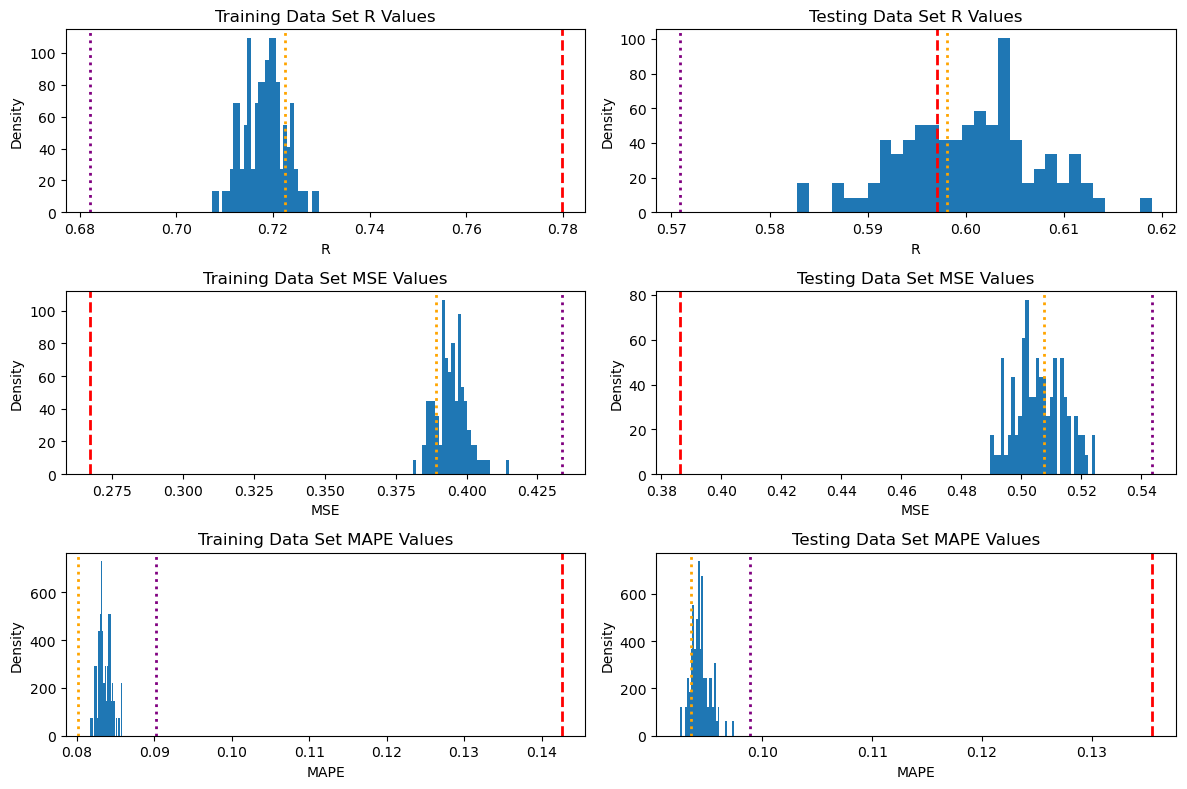

In [20]:
# Visualize the metrics in Gaussian curves along with reference values
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.hist(train_r_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["R"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["R"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["R"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set R Values')
plt.xlabel('R')
plt.ylabel('Density')

plt.subplot(3, 2, 2)
plt.hist(test_r_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["R"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["R"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["R"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set R Values')
plt.xlabel('R')
plt.ylabel('Density')

plt.subplot(3, 2, 3)
plt.hist(train_mse_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["MSE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["MSE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["MSE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set MSE Values')
plt.xlabel('MSE')
plt.ylabel('Density')

plt.subplot(3, 2, 4)
plt.hist(test_mse_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["MSE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["MSE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["MSE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set MSE Values')
plt.xlabel('MSE')
plt.ylabel('Density')

plt.subplot(3, 2, 5)
plt.hist(train_mape_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["MAPE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["MAPE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["MAPE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set MAPE Values')
plt.xlabel('MAPE')
plt.ylabel('Density')

plt.subplot(3, 2, 6)
plt.hist(test_mape_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["MAPE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["MAPE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["MAPE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set MAPE Values')
plt.xlabel('MAPE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()
